In [1]:
import numpy as np
import pyhdf
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
from datetime import datetime, timezone
from scipy import interpolate
import glob
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
from geopy.distance import geodesic
# from satpy import Scene

In [2]:
## ===============================================
def read_2b_cldclass_lidar(cs_file,latbin=None):
## ===============================================
  f_2b_cldclass_lidar=SD(cs_file, SDC.READ)
  sds_obj = f_2b_cldclass_lidar.select('CloudLayerBase')
  cs_clb = sds_obj.get()
  sds_obj = f_2b_cldclass_lidar.select('CloudLayerTop')
  cs_clt = sds_obj.get()
  sds_obj = f_2b_cldclass_lidar.select('CloudLayerType')
  cs_cltype = sds_obj.get()

  sdc_2bcldclass_lidar=HDF(cs_file, SDC.READ)
  vs_2bcldclass_lidar=sdc_2bcldclass_lidar.vstart()
  cs_QC = np.squeeze(vs_2bcldclass_lidar.attach('Data_quality')[:])
  Latitude = np.squeeze(vs_2bcldclass_lidar.attach('Latitude')[:])
  Longitude = np.squeeze(vs_2bcldclass_lidar.attach('Longitude')[:])

  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  cs_clb = cs_clb[ilat,:]
  cs_clt = cs_clt[ilat,:]
  cs_QC = cs_QC[ilat]
  cs_cltype = cs_cltype[ilat,:]
  Latitude = Latitude[ilat]
  Longitude = Longitude[ilat]

  return(cs_clb,cs_clt,cs_cltype,cs_QC,Latitude,Longitude)

## ===============================================
def read_cs_ecmwf(aux_file,latbin=None):
## ===============================================
  f_ecmwf=SD(aux_file, SDC.READ)
  sds_obj=f_ecmwf.select('Pressure')
  Pressure =sds_obj.get()
  sds_obj=f_ecmwf.select('Temperature')
  Temperature =sds_obj.get()
  sds_obj=f_ecmwf.select('Specific_humidity')
  Specific_humidity =sds_obj.get()
  #sds_obj=f_ecmwf.select('U_velocity')
  #U_velocity =sds_obj.get()
  #sds_obj=f_ecmwf.select('V_velocity')
  #V_velocity =sds_obj.get()

  sdc_ecmwf=HDF(aux_file, SDC.READ)
  vs_ecmwf=sdc_ecmwf.vstart()
  EC_height = np.squeeze(vs_ecmwf.attach('EC_height')[:])
  Profile_time = np.squeeze(vs_ecmwf.attach('Profile_time')[:])
  UTC_start = np.squeeze(vs_ecmwf.attach('UTC_start')[:])
  #TAI_start = np.squeeze(vs_ecmwf.attach('TAI_start')[:])
  Latitude = np.squeeze(vs_ecmwf.attach('Latitude')[:])
  Longitude = np.squeeze(vs_ecmwf.attach('Longitude')[:])
  DEM_elevation = np.squeeze(vs_ecmwf.attach('DEM_elevation')[:])
  Skin_temperature = np.squeeze(vs_ecmwf.attach('Skin_temperature')[:])
  Surface_pressure = np.squeeze(vs_ecmwf.attach('Surface_pressure')[:])
  Temperature_2m = np.squeeze(vs_ecmwf.attach('Temperature_2m')[:])
  #Sea_surface_temperature = np.squeeze(vs_ecmwf.attach('Sea_surface_temperature')[:])
  U10_velocity = np.squeeze(vs_ecmwf.attach('U10_velocity')[:])
  V10_velocity = np.squeeze(vs_ecmwf.attach('V10_velocity')[:])


  UTC_Time = UTC_start + Profile_time
  UTC_Time = UTC_Time/60./60.
  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  Pressure = Pressure[ilat,:]
  Temperature = Temperature[ilat,:]
  Specific_humidity = Specific_humidity[ilat,:]
  DEM_elevation = DEM_elevation[ilat]
  Skin_temperature = Skin_temperature[ilat]
  Temperature_2m = Temperature_2m[ilat]
  U10_velocity = U10_velocity[ilat]
  V10_velocity = V10_velocity[ilat]
  UTC_Time = UTC_Time[ilat]


  return(Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,U10_velocity,V10_velocity,UTC_Time)


In [3]:
def find_files(directory, prefix):
    matching_files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix):
            matching_files.append(os.path.join(directory, filename))
    return matching_files


In [4]:
def gather_files(YYYY, DDD, HH, ROOT):
    ABI_ = {
        "ROOT_PATH": None,

        "YYYY": None,
        "DDD": None,
        "HH": None,

        "00": [],
        "10": [],
        "15": [],
        "20": [],
        "30": [],
        "40": [],
        "45": [],
        "50": [],

        "L200": None,
        "L210": None,
        "L220": None,
        "L230": None,
        "L240": None,
        "L250": None,

        "everyten": False,
    }

    _ABI_PATH_ = ROOT + YYYY + "/" + DDD + "/" + HH

    for filename in os.listdir(_ABI_PATH_):
        if ABI_["ROOT_PATH"] == None:
            ABI_["ROOT_PATH"] = _ABI_PATH_
            ABI_["YYYY"] = filename[27:31]
            ABI_["DDD"] = filename[31:34]
            ABI_["HH"] = filename[34:36]
        MM = filename[36:38]
        if MM == "10":
            ABI_["everyten"] = True
        ABI_[f"{MM}"].append(filename)

    return ABI_

def get_L1B_L2(abipaths, l2path, YYYY, DDD, HH, ROOT):

    if len(abipaths) != 16:
        raise ImportError("This hour is bad")

    CHANNELS = []

    print("Loading Data")

    for file in abipaths:
        L1B = np.asarray(nc.Dataset(ROOT + YYYY + "/" + DDD + "/" + HH + "/" + file, 'r')["Rad"])
        CHANNEL = int(file[19:21])
        CHANNELS.append((L1B, CHANNEL))

    CHANNELS.sort(key=lambda x: x[1])
    CHANNELS = [C[0] for C in CHANNELS]

    T = []
    for C in CHANNELS:
        S = C.shape[0] // 5424
        if S == 1:
            C = np.repeat(C, 2, axis=0)
            C = np.repeat(C, 2, axis=1)
        if S == 4:
            C = C[::2, ::2]
        T.append(C)

    CHANNELS = T

    ABI = np.stack(CHANNELS, axis=2)

    return ABI


In [3]:
BOUND_SIZE = 1600
LENGTH = 10848

f = nc.Dataset("/explore/nobackup/projects/pix4dcloud/jgong/ABI_WEST_GEO_TOPO_LOMSK.nc")
abiLong = np.array(f['Longitude'])
abiLat = np.array(f['Latitude'])

abiLongB = abiLong[BOUND_SIZE:LENGTH-BOUND_SIZE, BOUND_SIZE:LENGTH-BOUND_SIZE]
abiLatB = abiLat[BOUND_SIZE:LENGTH-BOUND_SIZE, BOUND_SIZE:LENGTH-BOUND_SIZE]
abiLongB[abiLongB == -999] = 10
abiLatB[abiLatB == -999] = 10
longMin = abiLongB.min()
longMax = abiLongB.max()
latMin = abiLatB.min()
latMax = abiLatB.max()

GATHERED_ABI_FILES = {}
COLLECTED_ABI_DATA = {}

latSlice = abiLat[:, 5424]
latSlice = latSlice[18:-18]
longSlice = abiLong[5424, :]
longSlice = longSlice[18:-18]
latSlice = latSlice[::-1]

In [7]:
abiLongB[2537, 7585]

-97.67786

In [6]:
def interpArray(Temperature, EC_height):

    z_grid=np.arange(40)*0.5
    N = Temperature.shape[0]
    Temperature_grid = np.zeros((N, len(z_grid)))
    for i in range(N):
        Temperature_tmp=np.squeeze(Temperature[i,:])
        ivalid=np.squeeze(np.where(Temperature_tmp > 0))

        Temperature_grid[i, :]=np.interp(z_grid,np.flip(EC_height[ivalid]/1000.),np.flip(Temperature_tmp[ivalid]))

    return Temperature_grid

def processTime(t, yy, ddn, lat, lon, ABI_ROOT):
    if np.floor(t) < 19:
        raise ValueError("Times must be between 19-23")

    if lat < latMin or lat > latMax or lon < longMin or lon > longMax:
        raise ValueError("Latitude and Longitude are not correctly bounded")

    AREA_SIZE = 1000

    lati = len(latSlice) - np.searchsorted(latSlice, lat) + 17
    loni = np.searchsorted(longSlice, lon) + 18

    distances = np.abs(abiLat[lati-AREA_SIZE:lati+AREA_SIZE, loni-AREA_SIZE:loni+AREA_SIZE] - lat) + np.abs(abiLong[lati-AREA_SIZE:lati+AREA_SIZE, loni-AREA_SIZE:loni+AREA_SIZE] - lon)
    coords = np.array(np.unravel_index(distances.argmin(), distances.shape))
    if coords[0] == 0 or coords[1] == 0 or coords[1] == 2*AREA_SIZE-1 or coords[0] == 2*AREA_SIZE - 1:
        print("FALLBACK")
        distances = np.abs(abiLat - lat) + np.abs(abiLong - lon)
        coords = np.unravel_index(distances.argmin(), distances.shape)
    else:
        coords[0] += lati - AREA_SIZE
        coords[1] += loni - AREA_SIZE

    if coords[0] < BOUND_SIZE or coords[1] < BOUND_SIZE or coords[1] > LENGTH-BOUND_SIZE or coords[0] > LENGTH-BOUND_SIZE:
        raise ValueError("Bad latitude and longitude")

    hour = np.floor(t).astype(int)

    DATA = GATHERED_ABI_FILES.get(f'{yy}-{ddn}-{hour}')
    if DATA is None:
        DATA = gather_files(str(yy), str(ddn), str(hour), ABI_ROOT)
        GATHERED_ABI_FILES[f'{yy}-{ddn}-{hour}'] = DATA

    if DATA["everyten"]:
        minutes = np.round((t - np.floor(t)) * 6).astype(int) * 10
    else:
        minutes = np.round((t - np.floor(t)) * 4).astype(int) * 15

    if minutes == 60:
        if hour != 23:
            hour += 1
            minutes = 0
        else:
            if DATA["everyten"]:
                minutes = 50
            else:
                minutes = 45

    minutes = str(minutes)
    if minutes == "0":
        minutes ="00"

    ABI = COLLECTED_ABI_DATA.get(f'{yy}-{ddn}-{hour}-{minutes}')
    if ABI is None:
        ABI = get_L1B_L2(DATA[minutes], DATA["L200"], DATA["YYYY"], DATA["DDD"], DATA["HH"], ABI_ROOT)
        COLLECTED_ABI_DATA[f'{yy}-{ddn}-{hour}-{minutes}'] = ABI

    chip = ABI[coords[0]-64:coords[0]+64, coords[1]-64:coords[1]+64, :]

    return chip, coords


In [7]:
translation = [1, 2, 0, 4, 5, 6, 3, 8, 9, 10, 11, 13, 14, 15]

def processFile(yy, ddn, orbit, latb):
    cloudsatpath = '/explore/nobackup/projects/pix4dcloud/szhang16/cloudsat/'
    #cloudsatpath = '/discover/nobackup/jgong/cloudsat/'
    cs_file = glob.glob(cloudsatpath+'2B-CLDCLASS-LIDAR/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*2B-CLDCLASS-LIDAR*'+'P1_R05*.hdf')
    aux_file = glob.glob(cloudsatpath+'ECMWF-AUX/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*ECMWF-AUX*'+'P1_R05*.hdf')

    if len(cs_file) == 0 or len(aux_file) == 0:
        print("NO CS OR AUX")
        return

    [Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,\
        U10_velocity,V10_velocity,UTC_Time] = read_cs_ecmwf(aux_file[0],latbin=latb)

    ##========== read 2b-cldclass-lidar ================================
    [cs_clb,cs_clt,cs_cltype,cs_QC,Latitude,Longitude] = read_2b_cldclass_lidar(cs_file[0],latbin=latb)

    Pressure = interpArray(Pressure, EC_height)
    Temperature = interpArray(Temperature, EC_height)
    Specific_humidity = interpArray(Specific_humidity, EC_height)

    N = len(cs_clb)

    cs_clb_2 = np.floor(2 * cs_clb).astype(int)
    cs_clt_2 = np.floor(2 * cs_clt).astype(int)

    cloud_class_mask_40_level = np.zeros((N, 40), dtype=np.int8)

    for i in range(N):
        for j in range(10):
            if cs_clb[i, j] < 0:
                break
            start_idx = cs_clb_2[i, j]
            end_idx = cs_clt_2[i, j] + 1

            cloud_type = cs_cltype[i, j]

            cloud_class_mask_40_level[i, start_idx:end_idx] = cloud_type

    # Find corresponding ABI file to the UTC_Time

    i = 0

    while i < N:
        try:
            chip, coords = processTime(UTC_Time[i], yy, ddn, Latitude[i], Longitude[i], '/css/geostationary/BackStage/GOES-16-ABI-L1B-FULLD/')
        except ValueError:
            i += 20
            continue
        except ImportError:
            print("MISSING ABI DATA")
            print(yy, ddn, UTC_Time[i])
            i += 90
            continue

        # dRange = np.arange(i-45, i+46)
        # Reverse the CloudSAT Data
        dRange = np.arange(i+46, i-45, -1)
        aux_data = {
            "Pressure": Pressure[dRange],
            "DEM_elevation": DEM_elevation[dRange],
            "Temperature": Temperature[dRange],
            "Specific_humidity": Specific_humidity[dRange],
            "Temperature_2m": Temperature_2m[dRange],
            "U10_velocity": U10_velocity[dRange],
            "V10_velocity": V10_velocity[dRange],
            "UTC_Time": UTC_Time[dRange],
            "Latitude": Latitude[dRange],
            "Longitude": Longitude[dRange],
            "Cloud_mask": cloud_class_mask_40_level[dRange],
            "Cloud_mask_binary": (cloud_class_mask_40_level[dRange] != 0).astype(int),
            "Cloud_class": cs_cltype[dRange],
        }

        fileName = f'{yy}-{ddn}-{orbit}_{coords[0]}-{coords[1]}-{i}'

        # chip = chip[..., translation]

        np.savez('/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/' + fileName, chip=chip, data=aux_data)
        print(fileName, UTC_Time[i])

        i += 45


In [8]:
#=================================
#    MAIN
#=================================

ROOT_DIR = '/explore/nobackup/projects/pix4dcloud/szhang16/cloudsat/2B-CLDCLASS-LIDAR'

for year in os.listdir(ROOT_DIR):
    if year == "2018":
        continue
    for day in os.listdir(ROOT_DIR + '/' + year):
        for file in os.listdir(ROOT_DIR + '/' + year + '/' + day):
            if file.endswith('hdf'):
                orbit = file[14:19]
                if int(file[7:9]) > 18:
                    print(f"PROCESSING FILE {year} {day} {orbit}")
                    processFile(year, day, orbit, (latMin, latMax))


PROCESSING FILE 2019 001 67538
MISSING ABI DATA
2019 001 21.270707533094615
MISSING ABI DATA
2019 001 21.274707573784724
MISSING ABI DATA
2019 001 21.278707546657987
MISSING ABI DATA
2019 001 21.28270751953125
MISSING ABI DATA
2019 001 21.286707560221355
MISSING ABI DATA
2019 001 21.29070753309462
MISSING ABI DATA
2019 001 21.29470757378472
MISSING ABI DATA
2019 001 21.298707546657983
MISSING ABI DATA
2019 001 21.30270751953125
MISSING ABI DATA
2019 001 21.306707560221355
MISSING ABI DATA
2019 001 21.310707533094618
MISSING ABI DATA
2019 001 21.314707573784723
MISSING ABI DATA
2019 001 21.318707546657986
MISSING ABI DATA
2019 001 21.32270751953125
MISSING ABI DATA
2019 001 21.326707560221354
MISSING ABI DATA
2019 001 21.330707533094618
MISSING ABI DATA
2019 001 21.334707573784723
MISSING ABI DATA
2019 001 21.338707546657986
MISSING ABI DATA
2019 001 21.34270751953125
MISSING ABI DATA
2019 001 21.346707560221354
MISSING ABI DATA
2019 001 21.35070753309462
MISSING ABI DATA
2019 001 21.35

KeyboardInterrupt: 

In [9]:
sample_chip = np.load("/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/2019-005-67596_4276-2300-10155.npz", allow_pickle=True)

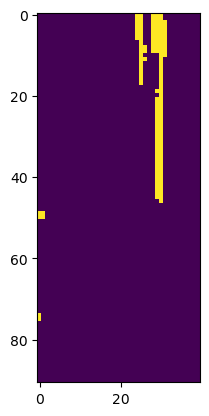

In [13]:
plt.imshow(sample_chip['data'].item()['Cloud_mask_binary'])

(128, 128, 16)